In [2]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

from torchvision.io import read_image
from pathlib import Path
from torchvision.utils import make_grid
from torchvision.utils import draw_bounding_boxes

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#https://tutorials.pytorch.kr/intermediate/torchvision_tutorial.html

# model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(num_classes=3, box_score_thresh=0.25, box_nms_thresh=0.5)
# load checkpoint
checkpoint = torch.load("./checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn/model_22.pth", map_location="cpu")
# load trained weights
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root, train=False, transforms=None):
        self.root = root
        self.train = train
        self.transforms = transforms
        self.imgs = sorted(glob.glob(root+'/*.jpg'))
        
        if train:
            self.boxes = sorted(glob.glob(root+'/*.txt'))

    def parse_boxes(self, box_path):
        with open(box_path, 'r') as file:
            lines = file.readlines()

        boxes = []
        labels = []

        for line in lines:
            values = list(map(float, line.strip().split(' ')))
            class_id = int(values[0])
            x_min, y_min = int(round(values[1])), int(round(values[2]))
            x_max, y_max = int(round(max(values[3], values[5], values[7]))), int(round(max(values[4], values[6], values[8])))

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        height, width = img.shape[0], img.shape[1]

        if self.train:
            box_path = self.boxes[idx]
            boxes, labels = self.parse_boxes(box_path)
            labels += 1 # Background = 0

            if self.transforms is not None:
                transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
                img, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
                
            return img, torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

        else:
            if self.transforms is not None:
                transformed = self.transforms(image=img)
                img = transformed["image"]
            file_name = img_path.split('/')[-1]
            return file_name, img, width, height

    def __len__(self):
        return len(self.imgs)
    

def get_test_transforms():
    return A.Compose([
        A.Resize(320, 320),
        ToTensorV2(),
    ])

In [5]:
test_dataset = CustomDataset('./import/dataset/test/images/', train=False, transforms=get_test_transforms())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def inference(model, test_loader, device):
    model.eval()
    model.to(device)
    outputs=[]
    
    #results = pd.read_csv('./sample_submission.csv')

    for img_files, images, img_width, img_height in tqdm(iter(test_loader)):
        images = [img.to(device) for img in images]

        with torch.no_grad():
            output = model(images)
            outputs.append((img_files,output))
            #print(outputs)
        
        # for idx, output in enumerate(outputs):
        #     boxes = output["boxes"].cpu().numpy()
        #     labels = output["labels"].cpu().numpy()
        #     scores = output["scores"].cpu().numpy()

    return outputs

outputs=inference(model, test_loader, device)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [03:08<00:00,  5.88s/it]


In [9]:
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

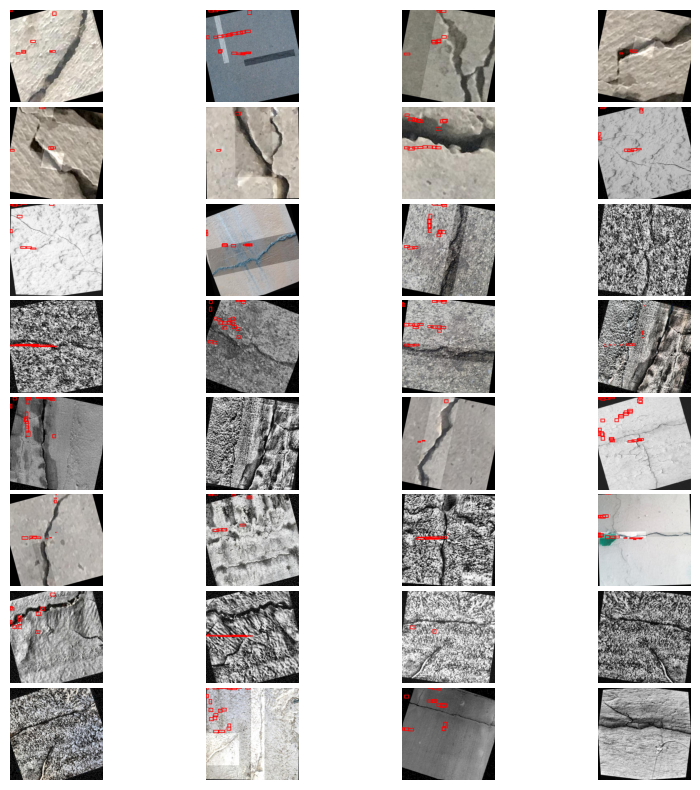

In [10]:
# boxes=outputs[0][1][2]['boxes']
# img_int = read_image("./import/dataset/test/"+outputs[0][0][2])
# colors = ["red"]*10
# result = draw_bounding_boxes(img_int, boxes, colors=colors, width=5)
# show(result)
results=[]
fig = plt.figure(figsize=(10, 10))

for i in range(len(outputs[0][0])):
    boxes=outputs[0][1][i]['boxes']
    img_int = read_image("./import/dataset/test/"+outputs[0][0][i])
    colors = ["red"]*len(boxes)
    result = draw_bounding_boxes(img_int, boxes, colors=colors, width=5)
    results.append(result)

for i, image_tensor in enumerate(results):
    # Convert the tensor to a NumPy array
    image_np = image_tensor.permute(1, 2, 0).numpy()

    # Create a subplot in the table
    ax = fig.add_subplot(8, 4, i+1)
    ax.imshow(image_np)
    ax.axis('off')

# Adjust the spacing and layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Show the plot
plt.show()